In [1]:
import torch
from torch import nn
from model import LSTMModel,BiLSTM_FullOutput
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
train_data_path = "../../train_hourly.csv"
test_data_path = "../../test_hourly.csv"

In [3]:
input_hours = 90 * 24       # 输入序列长度（90天）
output_hours = 90 * 24

use_cols = [
    'Global_active_power','Global_reactive_power',
    'Global_intensity','Sub_metering_1',
    'Sub_metering_2','Sub_metering_3',
    'sub_metering_remainder'
]

def load_hourly(path):
    df = pd.read_csv(path, parse_dates=['DateTime'])
    df.sort_values('DateTime', inplace=True)
    df.reset_index(drop=True, inplace=True)

    # 计算 sub_metering_remainder
    df["sub_metering_remainder"] = (
        df["Global_active_power"] * 1000 / 60
        - df["Sub_metering_1"]
        - df["Sub_metering_2"]
        - df["Sub_metering_3"]
    ).clip(lower=0)

    df = df[['DateTime'] + use_cols].copy()
    df.ffill(inplace=True)
    df.bfill(inplace=True)
    return df

train_df = load_hourly(train_data_path)
test_df  = load_hourly(test_data_path) 


full_df = pd.concat([train_df, test_df], ignore_index=True)

# ========= 标准化 ========= #
# scaler = MinMaxScaler()
# scaled = scaler.fit_transform(full_df[use_cols])
# target = scaled[:, 0]  # 目标值：Global_active_power
scaled = full_df[use_cols].values  # 直接使用原始值
target = scaled[:, 0]


# ========= 滑动窗口构造函数 ========= #
def build_samples(data, target, input_len, output_len, step=1):
    X, y = [], []
    for i in range(input_len, len(data) - output_len + 1, step):
        X.append(data[i - input_len:i])
        y.append(target[i:i + output_len])
    return np.array(X), np.array(y)

# ========= 构建样本 ========= #
X_all, y_all = build_samples(scaled, target, input_hours, output_hours, step=1)


# ========= 拆分 train / test ========= #
split_index = len(train_df) - input_hours  # 同样逻辑保证 test 在真实 test 部分
X_train = X_all[:split_index]
y_train = y_all[:split_index]
X_test  = X_all[split_index:]
y_test  = y_all[split_index:]


print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test  shape: {X_test.shape}")
print(f"y_test  shape: {y_test.shape}")

X_train shape: (15751, 2160, 7)
y_train shape: (15751, 2160)
X_test  shape: (14519, 2160, 7)
y_test  shape: (14519, 2160)


In [5]:
from torch.utils.data import TensorDataset, DataLoader, random_split
import matplotlib.pyplot as plt
import os

device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
batch_size = 256

train_ds = TensorDataset(
    torch.tensor(X_train, dtype=torch.float32),
    torch.tensor(y_train, dtype=torch.float32)
)
val_size = int(len(train_ds) * 0.2)
train_size = len(train_ds) - val_size
train_subset, val_subset = random_split(train_ds, [train_size, val_size])

train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

model = BiLSTM_FullOutput(
    input_size=7,
    hidden_size=128,
    output_len=2160,
    num_layers=2,
    dropout=0.3
).to(device)



criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-5)


In [6]:
train_losses, val_losses = [], []
best_val = float('inf')
best_model = None
patience = 10
no_improve = 0

os.makedirs("output", exist_ok=True)

Epoch 001 | Train Loss: 1.562765 | Val Loss: 1.149287 | MAE: 0.7313 | MSE: 1.1493
Epoch 002 | Train Loss: 0.996921 | Val Loss: 0.877278 | MAE: 0.7414 | MSE: 0.8773
Epoch 003 | Train Loss: 0.874620 | Val Loss: 0.859886 | MAE: 0.7456 | MSE: 0.8599
Epoch 004 | Train Loss: 0.855430 | Val Loss: 0.843948 | MAE: 0.7397 | MSE: 0.8439
Epoch 005 | Train Loss: 0.840063 | Val Loss: 0.830041 | MAE: 0.7333 | MSE: 0.8300
Epoch 006 | Train Loss: 0.826519 | Val Loss: 0.817085 | MAE: 0.7271 | MSE: 0.8171
Epoch 007 | Train Loss: 0.813294 | Val Loss: 0.804116 | MAE: 0.7203 | MSE: 0.8041
Epoch 008 | Train Loss: 0.799753 | Val Loss: 0.790316 | MAE: 0.7123 | MSE: 0.7903
Epoch 009 | Train Loss: 0.786062 | Val Loss: 0.775930 | MAE: 0.7027 | MSE: 0.7759
Epoch 010 | Train Loss: 0.772920 | Val Loss: 0.765490 | MAE: 0.6972 | MSE: 0.7655
Epoch 011 | Train Loss: 0.761513 | Val Loss: 0.754479 | MAE: 0.6892 | MSE: 0.7545
Epoch 012 | Train Loss: 0.751304 | Val Loss: 0.744263 | MAE: 0.6819 | MSE: 0.7443
Epoch 013 | Trai

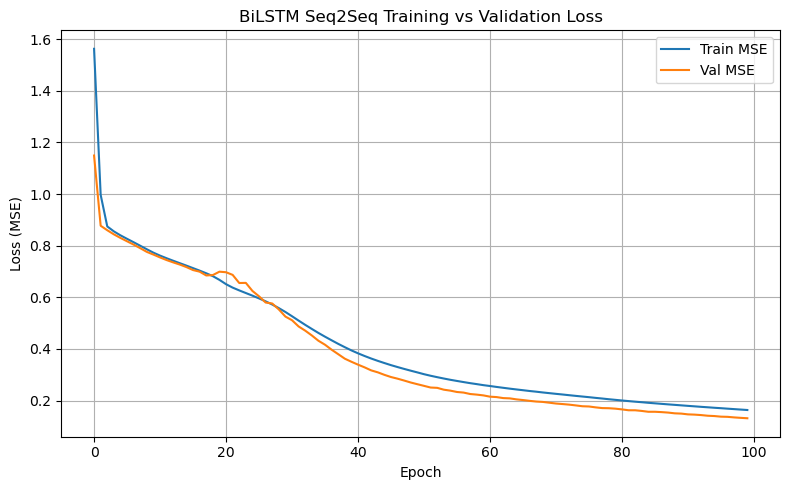

In [7]:
for epoch in range(1, 101):
    model.train()
    total_train_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        pred = model(xb)                            # shape: (B, 2160)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item() * xb.size(0)
    avg_train = total_train_loss / len(train_subset)
    train_losses.append(avg_train)

    # 验证阶段
    model.eval()
    total_val_loss = 0
    all_preds, all_gts = [], []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            loss = criterion(pred, yb)
            total_val_loss += loss.item() * xb.size(0)
            all_preds.append(pred.cpu().numpy())
            all_gts.append(yb.cpu().numpy())

    avg_val = total_val_loss / len(val_subset)
    val_losses.append(avg_val)
    all_preds = np.concatenate(all_preds, axis=0)
    all_gts = np.concatenate(all_gts, axis=0)
    val_mae = mean_absolute_error(all_gts, all_preds)
    val_mse = mean_squared_error(all_gts, all_preds)

    print(f"Epoch {epoch:03d} | Train Loss: {avg_train:.6f} | "
          f"Val Loss: {avg_val:.6f} | MAE: {val_mae:.4f} | MSE: {val_mse:.4f}")

    if avg_val < best_val:
        best_val = avg_val
        best_model = model.state_dict()
        torch.save(best_model, "output/best_bilstm_seq2seq.pth")
        no_improve = 0
    else:
        no_improve += 1
        if no_improve >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

# 绘制 loss 曲线
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Train MSE")
plt.plot(val_losses, label="Val MSE")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.title("BiLSTM Seq2Seq Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("output/loss_bilstm_seq2seq.png", dpi=300)
plt.show()

/tmp/ipykernel_230440/1717886604.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("output/best_bilstm_seq2seq.pth"))


[Test] MAE (hour): 0.6210 kW
[Test] RMSE (hour): 0.8438 kW


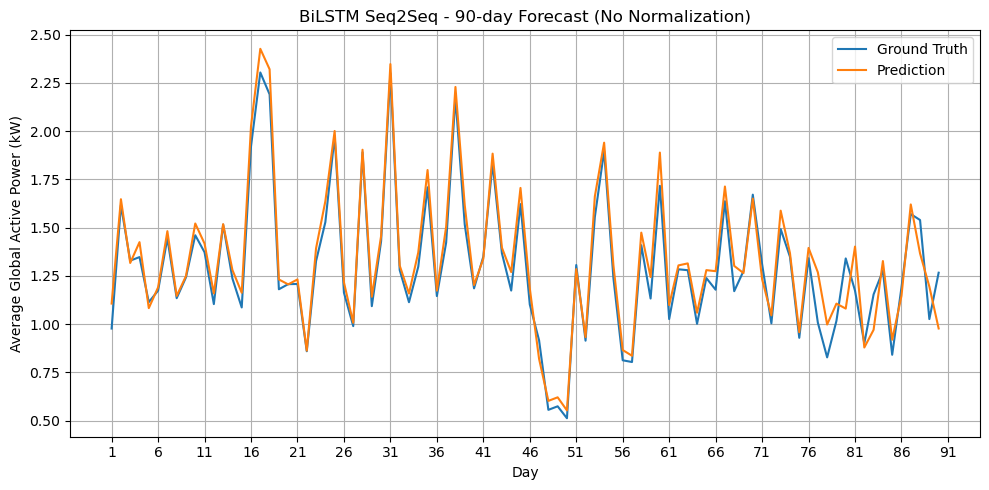

In [10]:
model.load_state_dict(torch.load("output/best_bilstm_seq2seq.pth"))
model.eval()

# === 测试集加载 ===
test_ds = torch.utils.data.TensorDataset(
    torch.tensor(X_test, dtype=torch.float32),
    torch.tensor(y_test, dtype=torch.float32)
)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=256, shuffle=False)

# === 模型推理 ===
preds, gts = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        pred = model(xb).cpu().numpy()  # (batch, 2160)
        preds.append(pred)
        gts.append(yb.numpy())

preds = np.concatenate(preds, axis=0)  # shape: (N_test, 2160)
gts   = np.concatenate(gts, axis=0)

# === 评估指标（原始单位） ===
mae = mean_absolute_error(gts, preds)
rmse = np.sqrt(mean_squared_error(gts, preds))
print(f"[Test] MAE (hour): {mae:.4f} kW")
print(f"[Test] RMSE (hour): {rmse:.4f} kW")

# === 每日聚合（取24小时均值） ===
preds_day = preds.reshape(-1, 90, 24).mean(axis=2)  # shape: (N, 90)
gts_day   = gts.reshape(-1, 90, 24).mean(axis=2)

# === 可视化（第一个样本） ===
plt.figure(figsize=(10, 5))
plt.plot(gts_day[0], label="Ground Truth", linewidth=1.5)
plt.plot(preds_day[0], label="Prediction", linewidth=1.5)
plt.xlabel("Day")
plt.ylabel("Average Global Active Power (kW)")
plt.title("BiLSTM Seq2Seq - 90-day Forecast (No Normalization)")
plt.xticks(ticks=np.arange(0, 91, 5), labels=[str(i+1) for i in range(0, 91, 5)])
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("output/bilstm_seq2seq_test_90day_noscale.png", dpi=300)
plt.show()
